In [19]:
##Testing notebook for heat eq solver with immersed boundary method
##need a gpu with at least 24 gb memory
import numpy as np
import torch
import jax.numpy as jnp
from jax import jit, grad, vmap
from scipy.spatial import KDTree
from jax.experimental import sparse

In [20]:
X_data = np.load("/home/iyer.ris/Pipe_X.npy")
Y_data = np.load("/home/iyer.ris/Pipe_Y.npy")
velocity_data=np.load("/home/iyer.ris/pipe/Pipe_Q.npy")
randPipeX = X_data[45]
randPipeY = Y_data[45]
randQ=velocity_data[45]
print(randQ.shape)
#print(randPipeX[20,0],randPipeY[20,0],randQ[2,-1,:])


(3, 129, 129)


In [22]:
class Heat_eq_generation():
    def __init__(self, x_channel, y_channel, velocity_data, domain_size, grid_res):
        self.x_channel = x_channel
        self.y_channel = y_channel
        coords_list = []
        for col in np.arange(x_channel.shape[1]):
            coords_list = coords_list + list(zip(x_channel[col, :], y_channel[col, :]))
        coords = jnp.array(coords_list)
        self.tree = KDTree(coords)
        Lx, Ly = domain_size
        Nx, Ny = grid_res
        nx, ny= grid_res
        x = jnp.linspace(0, Lx, Nx)
        y = jnp.linspace(-Ly, Ly, Ny)
        self.dx = Lx / Nx
        self.dy = 2 * Ly / Ny
        self.xgrid, self.ygrid = jnp.meshgrid(x, y)
        self.u = self.interpolate(velocity_data, self.xgrid, self.ygrid)
        self.mask = self.map_channel_geometry(self.xgrid, self.ygrid)
        alpha_aluminum = 64 * 10**-6
        alpha_water = 0.143 * 10**-6
        alpha_field = jnp.where(self.mask == True, alpha_water, alpha_aluminum)
        self.assemble_coefficients_matrix_vmapped = vmap(self.assemble_coefficients_matrix, in_axes=(0, 0, 0, None, None, None, None))
        self.apply_boundary_conditions_vmapped = vmap(self.apply_boundary_conditions, in_axes=(0, 0, 0, None, None, None, None))
        self.T = self.solve_steady_state(alpha_field, self.u[:,:,0], self.u[:,:,1], self.mask, nx, ny, self.dx, self.dy)


    def is_inside_channel(self, x, y):
        inside = False
        nearest_dist, nearest_idx = self.tree.query((x, y), 1)
        nearest_point = self.tree.data[nearest_idx]
        nearest_x, nearest_y = nearest_point

        # Find the indices where the nearest x-coordinate occurs in the meshgrid
        x_indices = np.where(self.x_channel == nearest_x)

        if len(x_indices[0]) > 0:
            # Check if the y-coordinate is within the range of y-coordinates at the nearest x-coordinate
            row_index, col_index = x_indices[0][0], x_indices[1][0]
            if self.y_channel[row_index, col_index] <= y <= self.y_channel[row_index, -1]:
                inside = True

        return inside

    def map_channel_geometry(self, X, Y):
        # Create a mask array to represent the channel geometry
        mask = np.zeros_like(X, dtype=bool)

        # Iterate over the grid points and determine if each point lies inside the channel
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                mask[i, j] = self.is_inside_channel(X[i, j], Y[i, j])

        return mask

    def interpolate(self, velocity_data, xgrid, ygrid):
        grid_points = jnp.stack((xgrid, ygrid), axis=-1)

        # Perform KDTree queries for all grid points
        distances, indices = self.tree.query(grid_points, k=4)

        # Parallelize the interpolation using vmap and jit
        interpolate_vectorized = jit(vmap(vmap(lambda point, dist, idx: self.interpolate_point(point, dist, idx, velocity_data), in_axes=(0, 0, 0)), in_axes=(0, 0, 0)))
        u = interpolate_vectorized(grid_points, distances, indices)

        return u

    @staticmethod
    @jit
    def interpolate_point(point, distances, indices, velocity_data):
        weights = 1.0 / distances
        weights /= jnp.sum(weights)

        velocity_sum = jnp.zeros(2)
        for k in range(4):
            idx = indices[k]
            row_idx, col_idx = jnp.unravel_index(idx, (velocity_data.shape[1], velocity_data.shape[2]))
            velocity_sum = velocity_sum.at[0].add(weights[k] * velocity_data[0, row_idx, col_idx])
            velocity_sum = velocity_sum.at[1].add(weights[k] * velocity_data[1, row_idx, col_idx])

        return velocity_sum

    
    
    @staticmethod
    def assemble_coefficients_matrix(alpha_field, velocity_field_x, velocity_field_y, nx, ny, dx, dy):
        A = jnp.zeros((nx * ny, nx * ny))
        
        for i in range(1, nx - 1):
            for j in range(1, ny - 1):
                index = i * ny + j
                
                # Diffusion terms
                A = A.at[index, index].add(-2 * alpha_field[i, j] / (dx**2) - 2 * alpha_field[i, j] / (dy**2))
                A = A.at[index, index - 1].add(alpha_field[i, j-1] / (dy**2))
                A = A.at[index, index + 1].add(alpha_field[i, j+1] / (dy**2))
                A = A.at[index, index - ny].add(alpha_field[i-1, j] / (dx**2))
                A = A.at[index, index + ny].add(alpha_field[i+1, j] / (dx**2))
                
                # Advection terms
                A = jax.lax.cond(
                    velocity_field_x[i, j] > 0,
                    lambda: A.at[index, index].add(-velocity_field_x[i, j] / dx).at[index, index - 1].add(velocity_field_x[i, j] / dx),
                    lambda: A.at[index, index].add(velocity_field_x[i, j] / dx).at[index, index + 1].add(-velocity_field_x[i, j] / dx)
                )
                
                A = jax.lax.cond(
                    velocity_field_y[i, j] > 0,
                    lambda: A.at[index, index].add(-velocity_field_y[i, j] / dy).at[index, index - ny].add(velocity_field_y[i, j] / dy),
                    lambda: A.at[index, index].add(velocity_field_y[i, j] / dy).at[index, index + ny].add(-velocity_field_y[i, j] / dy)
                )
        
        return A
        
    @staticmethod
    def apply_boundary_conditions(A, b, mask, nx, ny, dx, dy):
        for i in range(nx):
            for j in range(ny):
                index = i * ny + j
                
                if i == 0:
                    if mask[i, j] == True:
                        # Dirichlet BCs if in fluid inlet
                        A = A.at[index, index].set(1)
                        b = b.at[index].set(99)
                    else:
                        A = A.at[index, index].set(20 / 237 - 1 / dx)
                        A = A.at[index, index + ny].set(20 / 237 + 1 / dx)
                        b = b.at[index].set(400 / 237)  # h/k * air temp 20c room temp
                elif i == xgrid_shape[0] - 1:
                    if mask[i, j] == True:
                        # Fully thermally developed
                        A = A.at[index, index].set(1 / dx)
                        A = A.at[index, index - ny].set(-1 / dx)
                        b = b.at[index].set(0)
                    else:
                        A = A.at[index, index].set(20 / 237 + 1 / dx)
                        A = A.at[index, index - ny].set(20 / 237 - 1 / dx)
                        b = b.at[index].set(400 / 237)  # h/k * air temp 20c room temp
                elif j == 0:
                    A = A.at[index, index].set(20 / 237 - 1 / dy)
                    A = A.at[index, index + 1].set(20 / 237 + 1 / dy)
                    b = b.at[index].set(400 / 237)
                elif j == xgrid_shape[1] - 1:
                    A = A.at[index, index].set(20 / 237 + 1 / dy)
                    A = A.at[index, index - 1].set(20 / 237 - 1 / dy)
                    b = b.at[index].set(400 / 237)
        
        return A, b
    
    def solve_steady_state(self, alpha_field, velocity_field_x, velocity_field_y, mask, nx, ny, dx, dy):
        A = self.assemble_coefficients_matrix_vmapped(alpha_field[None], velocity_field_x[None], velocity_field_y[None], nx, ny, dx, dy)
        b = jnp.zeros(nx * ny)
        A, b = self.apply_boundary_conditions_vmapped(A, b[None], mask[None], nx, ny, dx, dy)
        T = solve(A[0], b[0], assume_a='pos').reshape((nx, ny))
        return T


domain_size = (10, 2.0)  # Domain size
grid_res = (100, 100)  # Grid resolution
heatobj = Heat_eq_generation(randPipeX, randPipeY, randQ, domain_size, grid_res)

2024-04-03 13:41:02.287381: W external/tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 381.47MiB (rounded to 400000000)requested by op 
2024-04-03 13:41:02.287864: W external/tsl/tsl/framework/bfc_allocator.cc:497] *******************************************************************_******************************__
2024-04-03 13:41:02.288114: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2461] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 400000000 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    1.12GiB
              constant allocation:         0B
        maybe_live_out allocation:  381.47MiB
     preallocated temp allocation:         0B
                 total allocation:    1.49GiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 381.47MiB
		Entry Parameter Subshape: s32[1,10000,10000]

	Buffe

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 400000000 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    1.12GiB
              constant allocation:         0B
        maybe_live_out allocation:  381.47MiB
     preallocated temp allocation:         0B
                 total allocation:    1.49GiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 381.47MiB
		Entry Parameter Subshape: s32[1,10000,10000]
		==========================

	Buffer 2:
		Size: 381.47MiB
		Entry Parameter Subshape: f32[1,10000,10000]
		==========================

	Buffer 3:
		Size: 381.47MiB
		Entry Parameter Subshape: f32[1,10000,10000]
		==========================

	Buffer 4:
		Size: 381.47MiB
		Operator: op_name="jit(select_n)/jit(main)/select_n" source_file="/tmp/ipykernel_7061/3816624692.py" source_line=101
		XLA Label: fusion
		Shape: f32[1,10000,10000]
		==========================



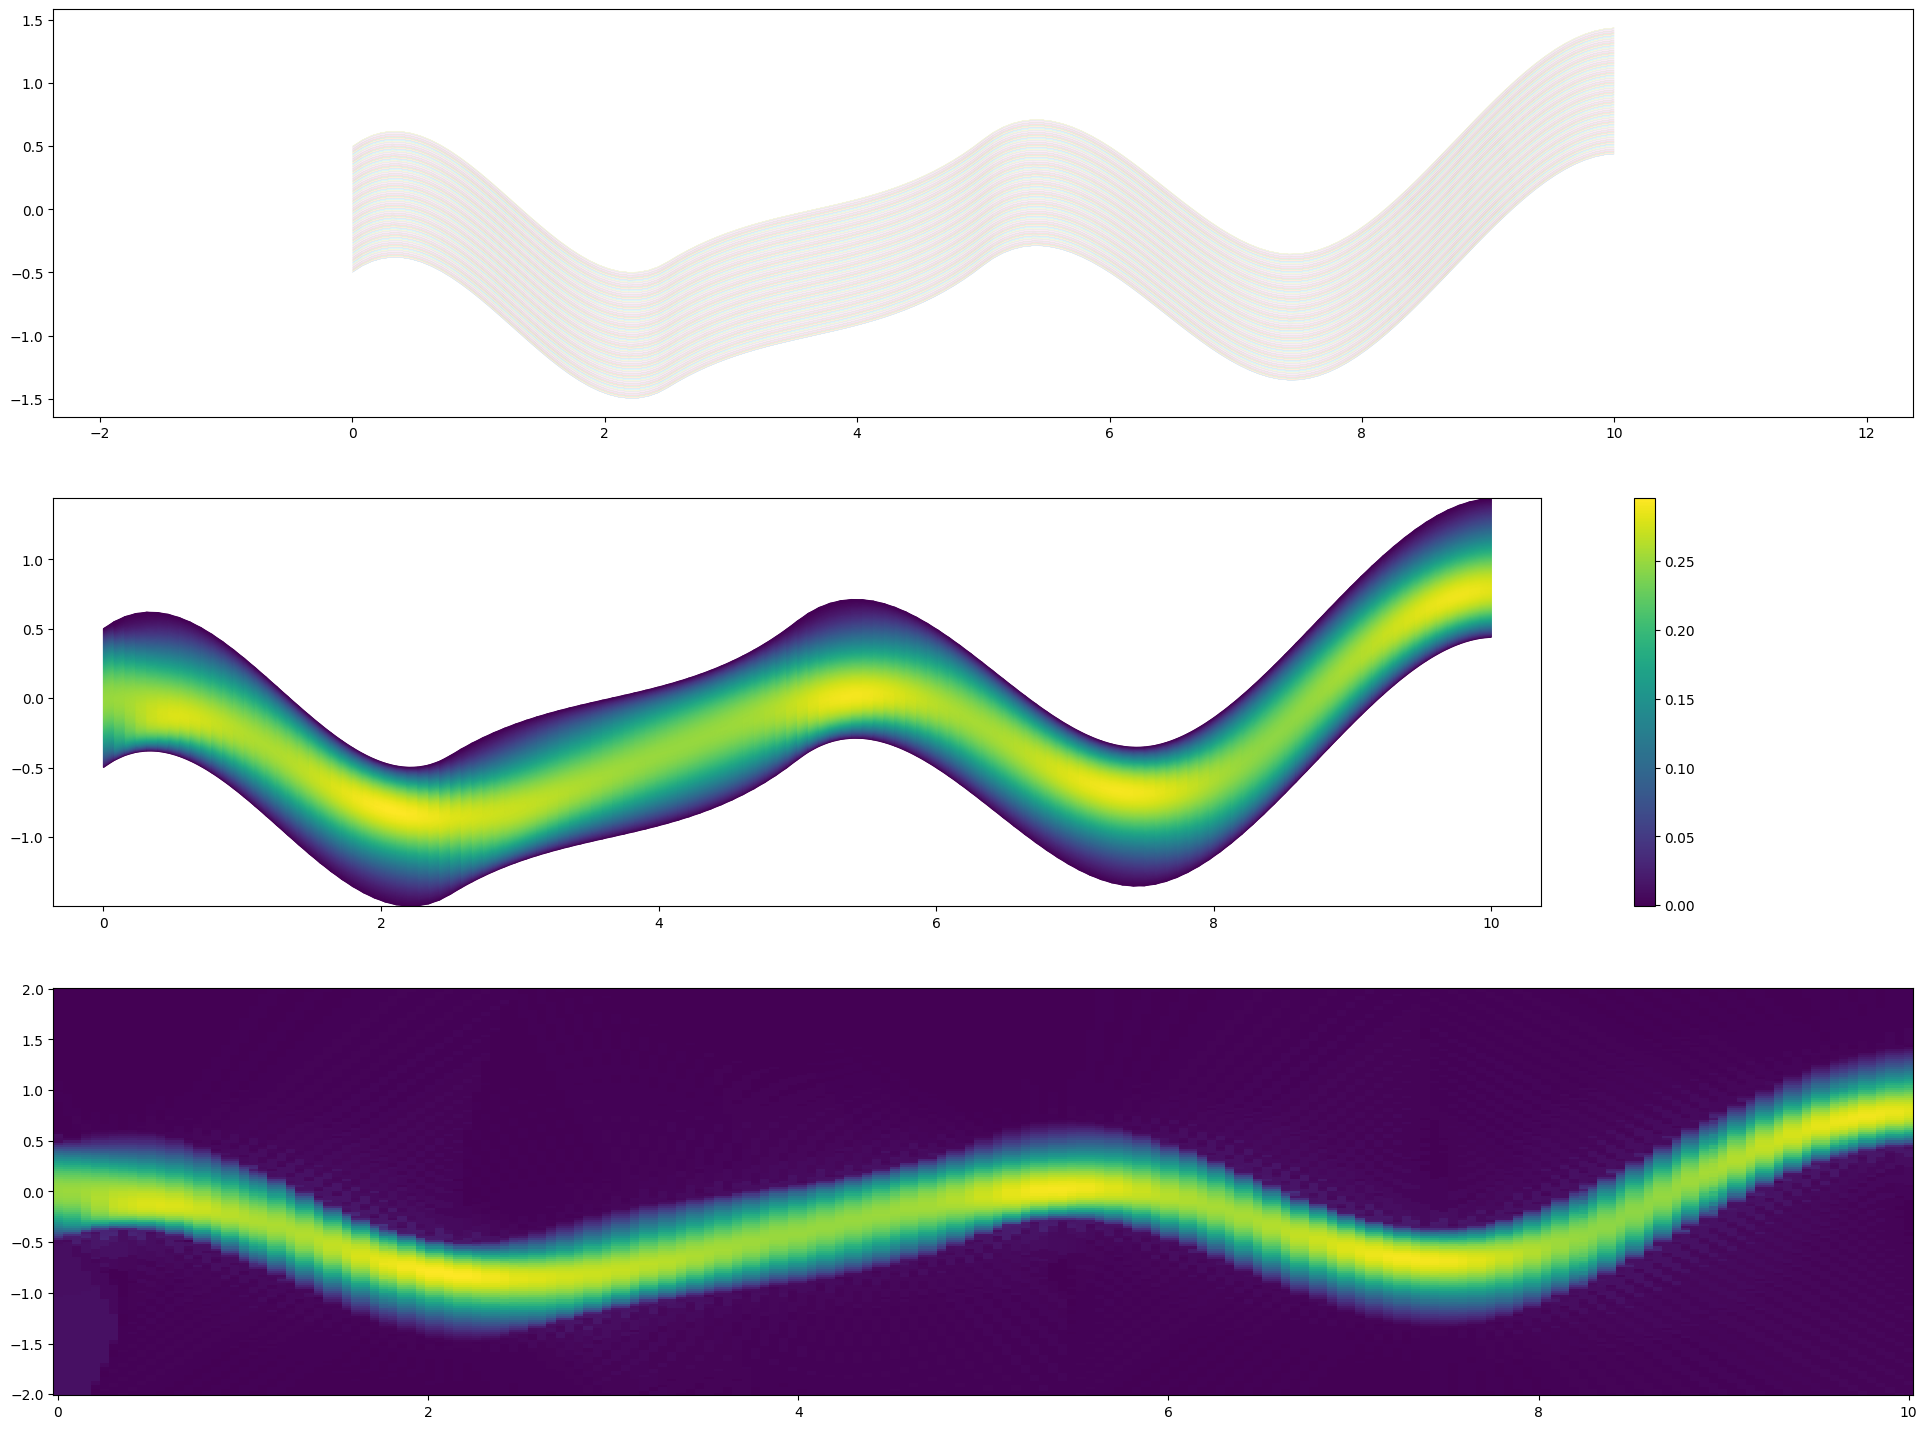

In [10]:
import matplotlib.pyplot as plt



fig,ax=plt.subplots(3,1,figsize=(24,18))
# Plot the original meshgrid
im0=ax[0].plot(randPipeX, randPipeY, '-', linewidth=0.1)
im1 = ax[1].pcolormesh(randPipeX,randPipeY, randQ[0,:,:], shading='gouraud')
im2= ax[2].pcolormesh(heatobj.xgrid,heatobj.ygrid,heatobj.u[:,:,0])
#ax1.plot(randPipeX.T, randPipeY.T, 'b-', linewidth=0.5)

ax[0].axis('equal')

fig.colorbar(im1, ax = ax[1])
ax[1].axis('equal')


# Display the plot
plt.show()
